In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, AutoModelForSequenceClassification
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class, get_dataloader
from src.model.sequence_classification.trainer import SequenceClassificationTrainer

import re
from typing import List, Dict
    

import warnings
warnings.filterwarnings("ignore")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
!mkdir logs
model_name = "Finetuning"
dataset_name = "RAFT-ADE"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)
device = "cuda" if torch.cuda.is_available() else "cpu"

mkdir: cannot create directory ‘logs’: File exists


## Get data

In [4]:
ade_corpus_dataset = load_dataset(
    "ought/raft", 
    name="ade_corpus_v2" , 
    cache_dir= "/Data/pedro.silva"
)

In [5]:
train_dataset = ade_corpus_dataset['train'].add_column(
    "labels",
    list(map(lambda x: x- 1, ade_corpus_dataset['train']['Label']))
)

test_dataset = ade_corpus_dataset['test'].add_column(
    "labels",
    list(map(lambda x: x- 1, ade_corpus_dataset['test']['Label']))
)

In [6]:
classes = np.unique(train_dataset['labels'], return_counts=True)
classes

(array([0, 1]), array([15, 35]))

In [21]:
classes_names = ["Non ADE related", "ADE related"]

In [7]:
num_classes = len(classes[0])

In [8]:
num_classes

2

In [9]:
train_size = 0.7
def stratified_train_test_split(
    dataset : Dataset,
    classes : np.ndarray,
    train_size : float
):
    """Performs train test split keeping class distributions

    Args:
        dataset (Dataset): _description_
        classes (np.ndarray): _description_
        train_size (float): _description_

    Returns:
        _type_: _description_
    """    

    indexes_dict = {}
    for label in classes[0]:
        indexes_dict[label] = []

    for i in range(len(train_dataset['labels'])):
        label = train_dataset['labels'][i]
        text = train_dataset['Sentence'][i]
        indexes_dict[label].append(text)


    train_data = {
        'labels': [],
        'text': []
    }

    validation_data = {
        "labels" : [],
        "text": []
    }

    # generating train data
    for label in classes[0]:
        n = len(indexes_dict[label])
        size = int(train_size * n)

        train_data['text'] += indexes_dict[label][:size]
        train_data['labels'] += [label]*size
        
        validation_data['text'] +=indexes_dict[label][size:]
        validation_data['labels'] += [label]* (n-size)

    return train_data, validation_data

In [10]:
train, val = stratified_train_test_split(
    train_dataset,
    classes,
    0.7
)

In [11]:
np.unique(train['labels'], return_counts=True)

(array([0, 1]), array([10, 24]))

In [12]:
np.unique(val['labels'],return_counts=True)

(array([0, 1]), array([ 5, 11]))

## Focal Loss Fn

In [30]:
_, class_counts = np.unique(
    train['labels'],
    return_counts=True,
)

alpha = len(train['labels'])/class_counts

In [43]:
from src.utils import FocalLoss
loss_fn = FocalLoss(
    gamma= 2,
    alpha= alpha
)

In [44]:
histories = {}
device = "cuda"

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)


bert = AutoModelForSequenceClassification\
    .from_pretrained("bert-base-uncased", num_labels = num_classes)\
    .to(device)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

trainer = SequenceClassificationTrainer(
    bert,
    num_classes
)
n_shots = len(train['text'])

train_dataloader = get_dataloader(
    train['text'],
    train['labels'],
    tokenizer,
    n_shots= n_shots,
    equalize_class= False,
    num_classes= num_classes,
)


val_dataloader = get_dataloader(
    val['text'],
    val['labels'],
    tokenizer,
    n_shots = 100,
    num_classes=num_classes,
    equalize_class=False
)


history = trainer.compile(
    train_dataloader,
    val_dataloader,
    loss_fn= loss_fn,
    evaluation_fn= binary_f1_score,
    n_epochs=20
)

histories[n_shots] = history

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 34/34 [00:01<00:00, 30.05it/s]


Text(0, 0.5, 'F1 score')

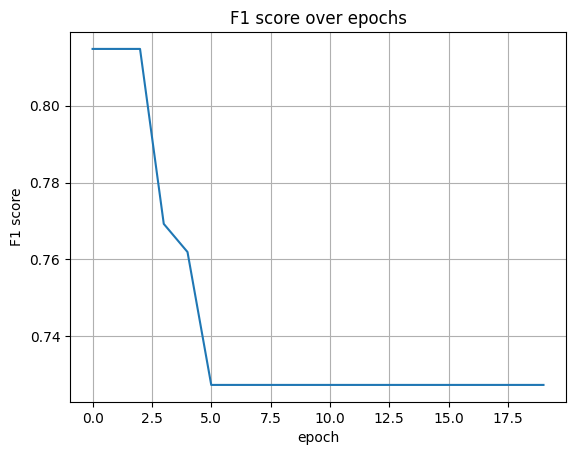

In [45]:
plt.plot(histories[n_shots]['val_f1'])
plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")

Text(0.5, 1.0, 'Confusion Matrix AG-News 100 shots')

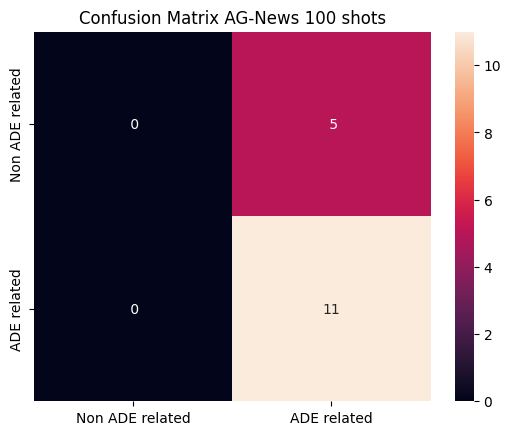

In [46]:
df = pd.DataFrame(
    history['val_conf_matrix'].to("cpu").numpy(),
    index = classes_names,
    columns=classes_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title("Confusion Matrix AG-News 100 shots")